# Generating Handwritten Digits using GAN

In this tutorial, you will learn to generate digits using a generative adversarial network using hand-written digits.
The tutorial will be divided into the following sections.

1. Retrieving and preparing the data
2. Initializing the model, loss function and optimizer
3. Training the model

In this tutorial, we will be using PyTorch.

In [1]:
%matplotlib inline
import typing as t

# Mathematical operations
import numpy as np

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F

# for seeing progress
from tqdm import tqdm

# For visualization
import matplotlib.pyplot as plt


## 1. Retrieving and preparing the data

In this tutorial, we will be using the MNIST dataset, which is a simple gray-scale handrwitten digit dataset composed of `28 x 28` images with numbers from 0 - 9. Getting the MNIST data is very simple using PyTorch, as `torchvision.datasets.mnist` already has built-in objects, allowing easy download, retrieval and access to the data.

In [2]:
from preprocess import get_gpu_device_safe, get_mnist_dataloader

# Training 
batch_size = 32
gpu_index = 0
train_dataloader = get_mnist_dataloader(batch_size, is_training_dataset = True)

### What does our data look like? 

The MNIST dataset looks like the following (sorry was too lazy to visualize)

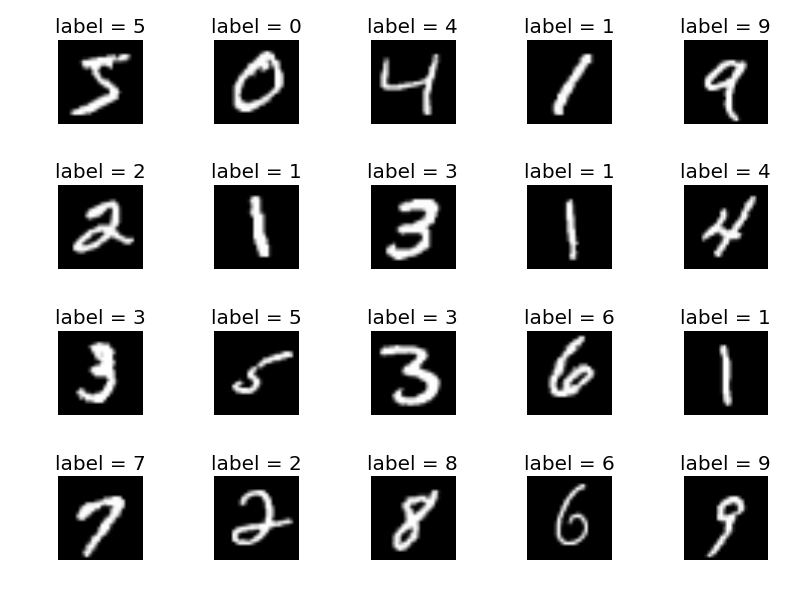


### Placing tensors on Devices

When training production-grade models that have tonnes of parameters, we often need to place our tensors on GPU for accelerated calculations. This works well, especially for convolution operations since it is parallelizable and thus runs really fast on GPUs. 

Although realistically, we use multiple gpus and nodes when training large models, the demo gives a sample of how to place tensors on a GPU device with `PyTorch`.

In [3]:
cuda = torch.device('cuda:0')
# Oops ... if we do this, we will get an error, since my mac does not have any cuda devices
# Moreover, my PyTorch version is compiled for CPU not GPU
tensor = torch.randn([10], device=cuda)

AssertionError: Torch not compiled with CUDA enabled

Often, it is good practice to check for available devices to ensure that it is available prior to allocating.

In [4]:
def get_gpu_device_safe(gpu_device: t.Union[torch.device, int]) -> torch.device:
    """
    Given a torch gpu or integer index of device, retrieve the device object if it is available.
    Otherwise, return error.
    Args:
        gpu_device: The torch gpu device object or index of gpu

    Returns:
        The torch.device object if available. Otherwise, return default cpu device.
    """
    if torch.cuda.is_available():
        device_index = gpu_device.index if isinstance(gpu_device, torch.device) else gpu_device
        if device_index < torch.cuda.device_count():
            return torch.device(f'cuda:{device_index}')
    return torch.device('cpu')

device = get_gpu_device_safe(torch.device('cuda:0'))
device 

device(type='cpu')

In the real-world, if we are training a supervised learning model that uses the input image or labels for evaluation, we would need a test dataset to evaluate the models performance to see whether it is generalizing well. Howerver, for GAN, there is no concrete metric for evaluating its performance. 

In this case, the best form of evaluation is seeing with our own eyes.

## 2. Initializing the model, loss function and optimizer


In this phase, we will initialize the two models: the `Discriminator` and the `Generator`. Because the discrimination task is a lot easier than the generation task, we need a more complex model for the Generator. Otherwise, the discriminator will overwhelm the generator and thus, the generator won't be properly trained.

In [5]:
from models import get_discriminator_and_generator

# size of latent vector
latent_dim = 100
discriminator, generator = get_discriminator_and_generator(latent_dim, device)
print(discriminator)
print(generator)

Discriminator(
  (network): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
  )
  (output_layer): Sequential(
    (0): Linear(in_features=256, out_features=1, bias=True)
    (1): Sigmoid()
  )
)
Generator(
  (layer_1): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Linear(in_features=128, out_features=256, bias=True)
    (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer_2): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): Bat

### Initializing the optimizers

In order to train our model, we need to update the parameters. To do that, we need to use an optimizer.


In [6]:
from torch.optim import SGD

# 0.0001
learning_rate = 1e-4 # Optimizer
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(),
                                           lr=learning_rate,
                                           betas=(0.5, 0.999),
                                           weight_decay=1e-3)
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

### Loss function

Now, we need to specify the loss function. Remember that there are two components

1. Discriminator: Binary Cross Entropy Loss
2. Generator = Binay Cross Entropy Loss

so we only need one loss function.
Often in PyTorch coding, the loss function is called the `criterion` but you dont have to follow this format

In [7]:
# loss function (We will be using the functional version since I don't want to pass it around as an argument)
binary_cross_entropy_loss = nn.BCELoss().to(device)

## 3. Training the model

This process is the most involved, so be prepared. Before we start, we will define all the remaining required variables.

In [8]:
# Training
batch_size: int = 32
epochs: int = 10
logging_interval: int = 300
    
# Image dimensions - MNIST is 28 x 28 gray-scale images
width, height = 28, 28
flattened_image_dim = width * height

discriminator.train()
generator.train()

# Ground-truth labels
# Dimension: (batch_size, 1)
gt_real = torch.tensor([0.9] * batch_size, device=device, requires_grad=False).reshape(batch_size, 1)
gt_fake = torch.tensor([0.1] * batch_size, device=device, requires_grad=False).reshape(batch_size, 1)

# For visualizing loss plot
discriminator_loss_per_epoch = []
generator_loss_per_epoch = []

### 3.1 Training Generator

The generator is rewarded for generating images that can fool the discrminator. Therefore in pseudocode, our loss will look something like this

```python
loss = binary_cross_entropy_loss(D(G(z), real_labels)
```

In [9]:
def train_generator_and_get_loss(generator: nn.Module,
                                 discriminator: nn.Module,
                                 batch_size: int,
                                 latent_dim: int,
                                 device: t.Union[torch.device, int],
                                 gt_real: torch.Tensor,
                                 optimizer: torch.optim.Optimizer) -> torch.Tensor:
    # Train generator
    # ----------------------------

    # Clear all previously accumulated gradients
    optimizer.zero_grad()

    fake_images = generate_fake_images(generator, batch_size, latent_dim, device)
    discriminator_fake = discriminator(fake_images)

    # Loss is minimized by fooling the discriminator into thinking the image is real
    generator_loss = F.binary_cross_entropy(discriminator_fake, gt_real)

    # Backprop
    generator_loss.backward()
    optimizer.step()

    return generator_loss

### 3.2 Train Discriminator

Training the discriminator is slightly more involved than the generator because we have to evaluate both the real and fake images. Thus, we will have two components as follows:

```python
real_image_loss = binary_cross_entropy_loss(D(G(z), fake_labels)
fake_image_loss = binary_cross_entropy_loss(D(x), real_labels)
total_loss = (real_image_loss + fake_image_loss) / 2
```

In [10]:
def train_discriminator_and_get_loss(generator: nn.Module,
                                     discriminator: nn.Module,
                                     real_images: torch.Tensor,
                                     batch_size: int,
                                     latent_dim: int,
                                     device: t.Union[torch.device, int],
                                     gt_real: torch.Tensor,
                                     gt_fake: torch.Tensor,
                                     optimizer: torch.optim.Optimizer
                                     ) -> torch.Tensor:
    # Set all accumulated gradients to zero
    optimizer.zero_grad()

    # we are not accumulating gradients here since we are training discriminator
    with torch.no_grad():
        fake_images = generate_fake_images(generator, batch_size, latent_dim, device).detach()

    # combine the real and fake images into a single batch
    discriminator_fake = discriminator(fake_images)
    discriminator_real = discriminator(real_images)

    # Calculate loss: divide by 2 since we are doubling the batch size by including fake images
    loss_real = F.binary_cross_entropy(discriminator_real, gt_real)
    loss_fake = F.binary_cross_entropy(discriminator_fake, gt_fake)
    discriminator_loss = (loss_real + loss_fake) / 2

    # Backprop
    discriminator_loss.backward()
    # Update the parameters
    optimizer.step()

    return discriminator_loss

### 3.3 Training loop

Now we will begin training the model.

In [11]:
# helper functions
from util import generate_fake_images, print_stats, visualize_loss, visualize_tensors

10it [00:00, 49.27it/s]

[epoch 0 / 10]: current_step: 0, disc_loss: 0.69777, generator_loss: 0.69553


311it [00:05, 62.21it/s]

[epoch 0 / 10]: current_step: 300, disc_loss: 0.62776, generator_loss: 0.79058


612it [00:09, 62.68it/s]

[epoch 0 / 10]: current_step: 600, disc_loss: 0.63893, generator_loss: 0.89072


913it [00:14, 62.63it/s]

[epoch 0 / 10]: current_step: 900, disc_loss: 0.66925, generator_loss: 0.76268


1207it [00:19, 62.55it/s]

[epoch 0 / 10]: current_step: 1200, disc_loss: 0.60408, generator_loss: 0.75795


1508it [00:24, 61.11it/s]

[epoch 0 / 10]: current_step: 1500, disc_loss: 0.63278, generator_loss: 0.75121


1812it [00:29, 61.40it/s]

[epoch 0 / 10]: current_step: 1800, disc_loss: 0.61699, generator_loss: 0.97291


1875it [00:30, 61.61it/s]


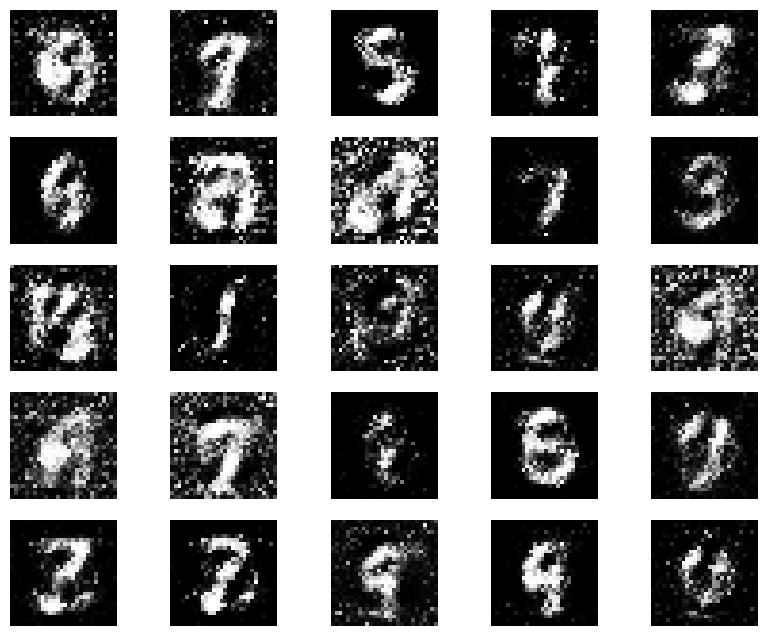

7it [00:00, 32.47it/s]

[epoch 1 / 10]: current_step: 0, disc_loss: 0.63287, generator_loss: 0.88771


307it [00:05, 62.09it/s]

[epoch 1 / 10]: current_step: 300, disc_loss: 0.59896, generator_loss: 0.77149


613it [00:09, 62.28it/s]

[epoch 1 / 10]: current_step: 600, disc_loss: 0.58147, generator_loss: 0.81938


910it [00:14, 63.41it/s]

[epoch 1 / 10]: current_step: 900, disc_loss: 0.63122, generator_loss: 0.82916


1211it [00:19, 62.88it/s]

[epoch 1 / 10]: current_step: 1200, disc_loss: 0.62127, generator_loss: 0.95291


1512it [00:24, 61.74it/s]

[epoch 1 / 10]: current_step: 1500, disc_loss: 0.59785, generator_loss: 0.72610


1813it [00:29, 62.66it/s]

[epoch 1 / 10]: current_step: 1800, disc_loss: 0.62058, generator_loss: 0.97202


1875it [00:30, 62.17it/s]


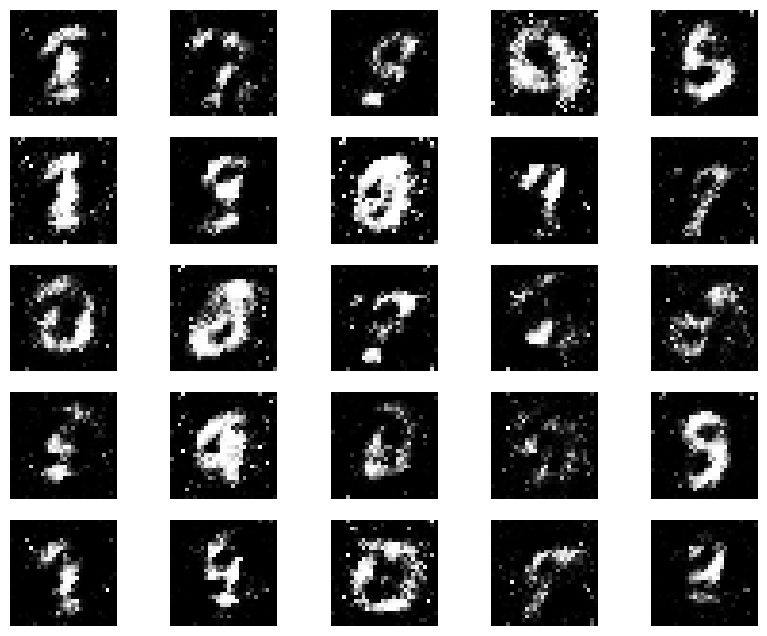

12it [00:00, 56.46it/s]

[epoch 2 / 10]: current_step: 0, disc_loss: 0.60056, generator_loss: 0.83744


313it [00:05, 62.92it/s]

[epoch 2 / 10]: current_step: 300, disc_loss: 0.59206, generator_loss: 1.08359


607it [00:09, 62.85it/s]

[epoch 2 / 10]: current_step: 600, disc_loss: 0.57728, generator_loss: 1.03508


908it [00:14, 62.86it/s]

[epoch 2 / 10]: current_step: 900, disc_loss: 0.62232, generator_loss: 0.63467


1209it [00:19, 63.02it/s]

[epoch 2 / 10]: current_step: 1200, disc_loss: 0.59445, generator_loss: 1.09744


1510it [00:23, 63.00it/s]

[epoch 2 / 10]: current_step: 1500, disc_loss: 0.59663, generator_loss: 1.02033


1811it [00:28, 62.65it/s]

[epoch 2 / 10]: current_step: 1800, disc_loss: 0.60484, generator_loss: 0.78815


1875it [00:29, 63.04it/s]


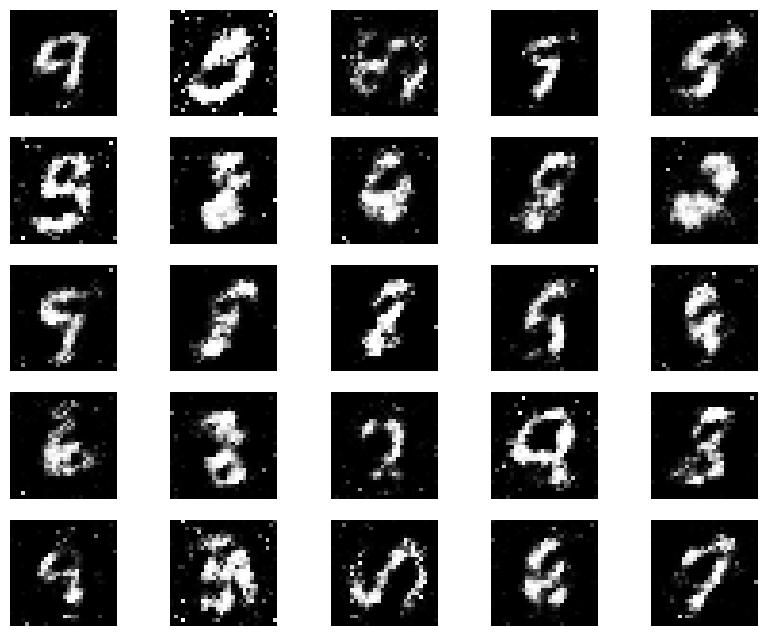

12it [00:00, 55.48it/s]

[epoch 3 / 10]: current_step: 0, disc_loss: 0.60475, generator_loss: 0.80002


313it [00:05, 61.73it/s]

[epoch 3 / 10]: current_step: 300, disc_loss: 0.58320, generator_loss: 0.97728


607it [00:09, 62.40it/s]

[epoch 3 / 10]: current_step: 600, disc_loss: 0.58760, generator_loss: 1.15083


908it [00:14, 62.16it/s]

[epoch 3 / 10]: current_step: 900, disc_loss: 0.66995, generator_loss: 0.63396


1209it [00:19, 61.34it/s]

[epoch 3 / 10]: current_step: 1200, disc_loss: 0.56313, generator_loss: 1.02492


1510it [00:24, 61.66it/s]

[epoch 3 / 10]: current_step: 1500, disc_loss: 0.58524, generator_loss: 1.16473


1811it [00:29, 62.09it/s]

[epoch 3 / 10]: current_step: 1800, disc_loss: 0.67591, generator_loss: 1.06392


1875it [00:30, 62.09it/s]


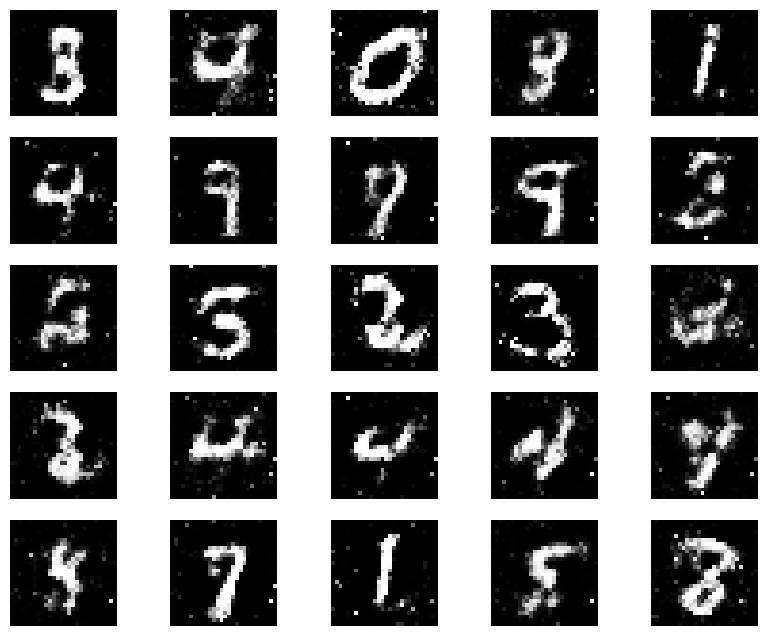

12it [00:00, 56.58it/s]

[epoch 4 / 10]: current_step: 0, disc_loss: 0.62991, generator_loss: 0.73795


312it [00:05, 62.05it/s]

[epoch 4 / 10]: current_step: 300, disc_loss: 0.63917, generator_loss: 0.79589


613it [00:09, 61.86it/s]

[epoch 4 / 10]: current_step: 600, disc_loss: 0.66455, generator_loss: 0.96970


907it [00:14, 61.45it/s]

[epoch 4 / 10]: current_step: 900, disc_loss: 0.61324, generator_loss: 0.78621


1208it [00:19, 61.22it/s]

[epoch 4 / 10]: current_step: 1200, disc_loss: 0.62922, generator_loss: 0.89799


1509it [00:24, 61.40it/s]

[epoch 4 / 10]: current_step: 1500, disc_loss: 0.63522, generator_loss: 0.75202


1810it [00:29, 61.76it/s]

[epoch 4 / 10]: current_step: 1800, disc_loss: 0.60014, generator_loss: 0.78142


1875it [00:30, 61.89it/s]


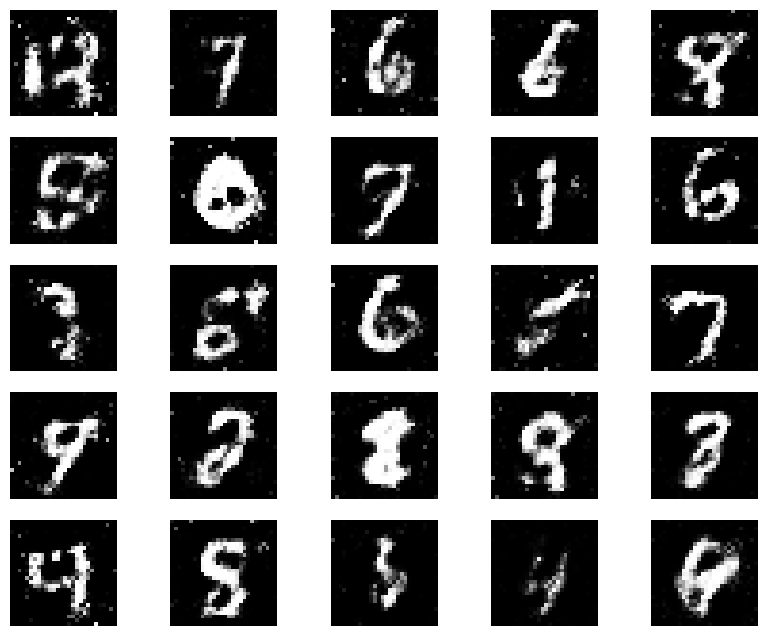

12it [00:00, 56.45it/s]

[epoch 5 / 10]: current_step: 0, disc_loss: 0.65329, generator_loss: 0.78836


313it [00:05, 61.90it/s]

[epoch 5 / 10]: current_step: 300, disc_loss: 0.63622, generator_loss: 0.83347


607it [00:09, 61.58it/s]

[epoch 5 / 10]: current_step: 600, disc_loss: 0.66539, generator_loss: 1.04429


908it [00:14, 62.08it/s]

[epoch 5 / 10]: current_step: 900, disc_loss: 0.62132, generator_loss: 0.71562


1209it [00:19, 62.13it/s]

[epoch 5 / 10]: current_step: 1200, disc_loss: 0.60962, generator_loss: 0.75909


1510it [00:24, 61.35it/s]

[epoch 5 / 10]: current_step: 1500, disc_loss: 0.64582, generator_loss: 0.75942


1811it [00:29, 61.88it/s]

[epoch 5 / 10]: current_step: 1800, disc_loss: 0.61343, generator_loss: 0.75725


1875it [00:30, 61.98it/s]


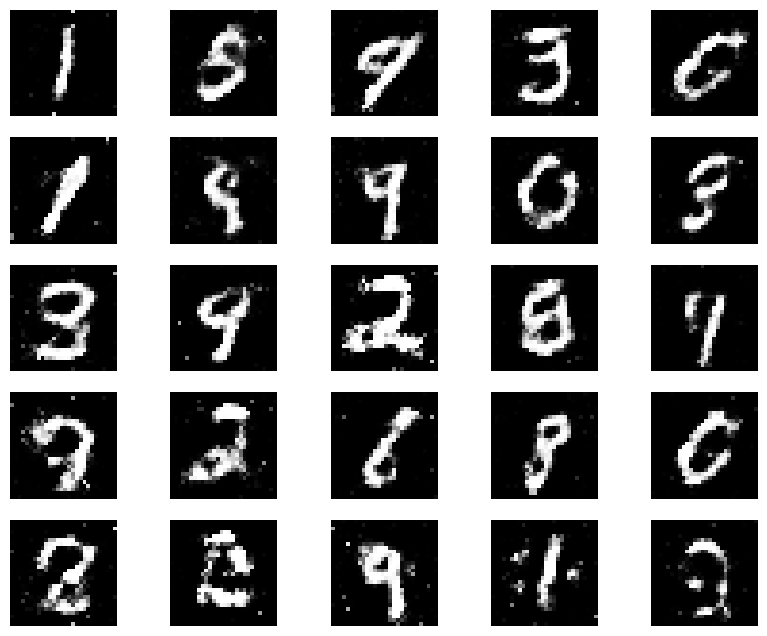

12it [00:00, 57.69it/s]

[epoch 6 / 10]: current_step: 0, disc_loss: 0.63870, generator_loss: 0.84481


313it [00:05, 62.25it/s]

[epoch 6 / 10]: current_step: 300, disc_loss: 0.62437, generator_loss: 0.90953


607it [00:09, 62.09it/s]

[epoch 6 / 10]: current_step: 600, disc_loss: 0.63832, generator_loss: 0.96826


908it [00:14, 62.78it/s]

[epoch 6 / 10]: current_step: 900, disc_loss: 0.63261, generator_loss: 0.85900


1209it [00:19, 62.47it/s]

[epoch 6 / 10]: current_step: 1200, disc_loss: 0.68248, generator_loss: 1.19931


1510it [00:24, 62.07it/s]

[epoch 6 / 10]: current_step: 1500, disc_loss: 0.60900, generator_loss: 0.80105


1811it [00:29, 61.08it/s]

[epoch 6 / 10]: current_step: 1800, disc_loss: 0.58396, generator_loss: 0.87577


1875it [00:30, 62.38it/s]


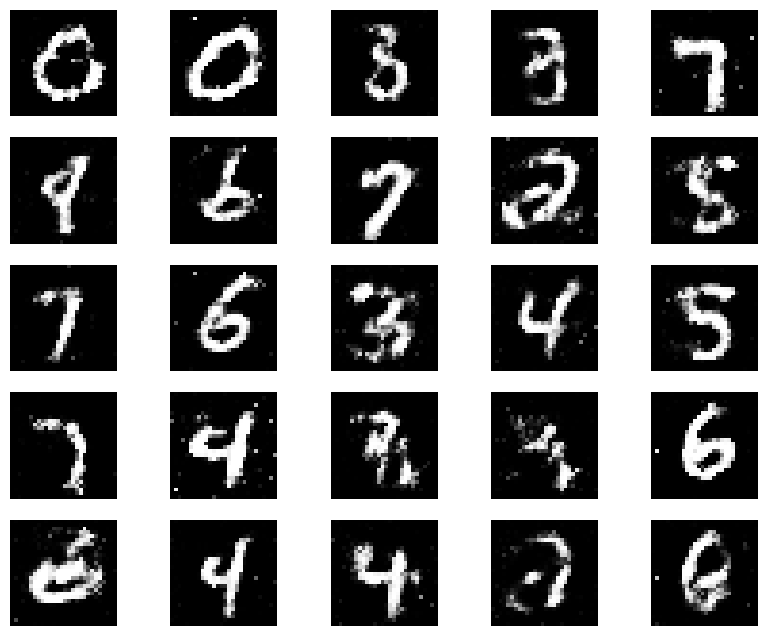

13it [00:00, 59.53it/s]

[epoch 7 / 10]: current_step: 0, disc_loss: 0.62627, generator_loss: 1.05114


307it [00:04, 61.63it/s]

[epoch 7 / 10]: current_step: 300, disc_loss: 0.61569, generator_loss: 0.76114


608it [00:09, 62.12it/s]

[epoch 7 / 10]: current_step: 600, disc_loss: 0.68812, generator_loss: 0.76410


909it [00:14, 62.61it/s]

[epoch 7 / 10]: current_step: 900, disc_loss: 0.71697, generator_loss: 0.59159


1210it [00:19, 62.34it/s]

[epoch 7 / 10]: current_step: 1200, disc_loss: 0.61846, generator_loss: 0.94087


1511it [00:24, 62.47it/s]

[epoch 7 / 10]: current_step: 1500, disc_loss: 0.65114, generator_loss: 0.94340


1812it [00:29, 62.01it/s]

[epoch 7 / 10]: current_step: 1800, disc_loss: 0.63424, generator_loss: 0.76866


1875it [00:30, 62.44it/s]


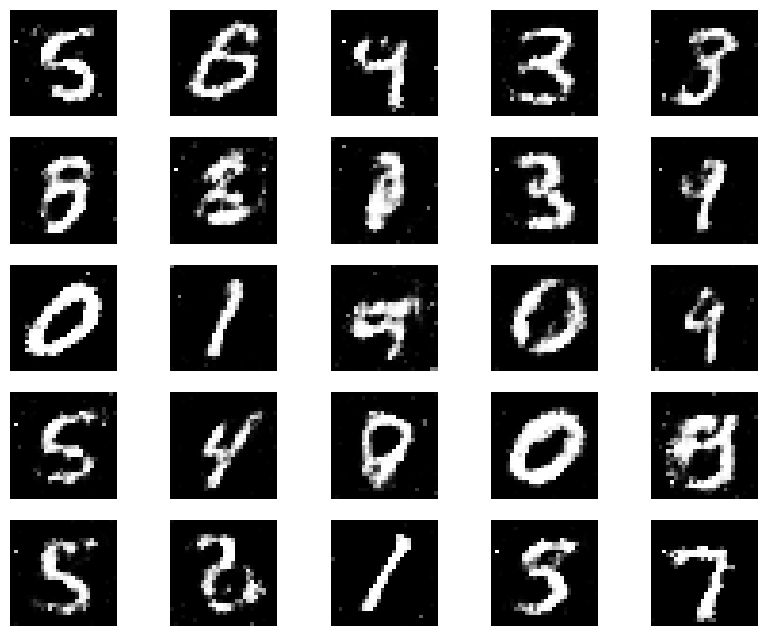

12it [00:00, 55.91it/s]

[epoch 8 / 10]: current_step: 0, disc_loss: 0.66479, generator_loss: 0.76050


312it [00:05, 60.91it/s]

[epoch 8 / 10]: current_step: 300, disc_loss: 0.64236, generator_loss: 0.91813


613it [00:09, 61.63it/s]

[epoch 8 / 10]: current_step: 600, disc_loss: 0.66213, generator_loss: 0.59671


907it [00:14, 61.27it/s]

[epoch 8 / 10]: current_step: 900, disc_loss: 0.61870, generator_loss: 0.96646


1208it [00:19, 60.99it/s]

[epoch 8 / 10]: current_step: 1200, disc_loss: 0.63562, generator_loss: 0.82693


1509it [00:24, 61.06it/s]

[epoch 8 / 10]: current_step: 1500, disc_loss: 0.62894, generator_loss: 0.81962


1810it [00:29, 61.25it/s]

[epoch 8 / 10]: current_step: 1800, disc_loss: 0.60418, generator_loss: 0.87939


1875it [00:30, 61.45it/s]


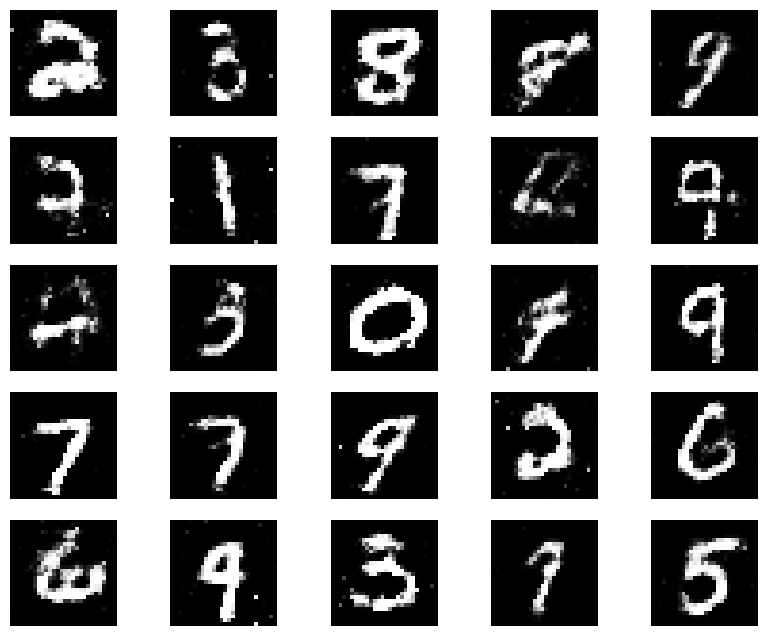

12it [00:00, 56.88it/s]

[epoch 9 / 10]: current_step: 0, disc_loss: 0.65573, generator_loss: 0.90884


313it [00:05, 61.88it/s]

[epoch 9 / 10]: current_step: 300, disc_loss: 0.63374, generator_loss: 0.66300


607it [00:09, 61.91it/s]

[epoch 9 / 10]: current_step: 600, disc_loss: 0.66352, generator_loss: 0.69814


908it [00:14, 61.47it/s]

[epoch 9 / 10]: current_step: 900, disc_loss: 0.62401, generator_loss: 0.74104


1209it [00:19, 60.52it/s]

[epoch 9 / 10]: current_step: 1200, disc_loss: 0.63866, generator_loss: 0.83614


1510it [00:24, 60.32it/s]

[epoch 9 / 10]: current_step: 1500, disc_loss: 0.64170, generator_loss: 0.68194


1811it [00:29, 61.08it/s]

[epoch 9 / 10]: current_step: 1800, disc_loss: 0.65920, generator_loss: 0.63588


1875it [00:30, 61.24it/s]


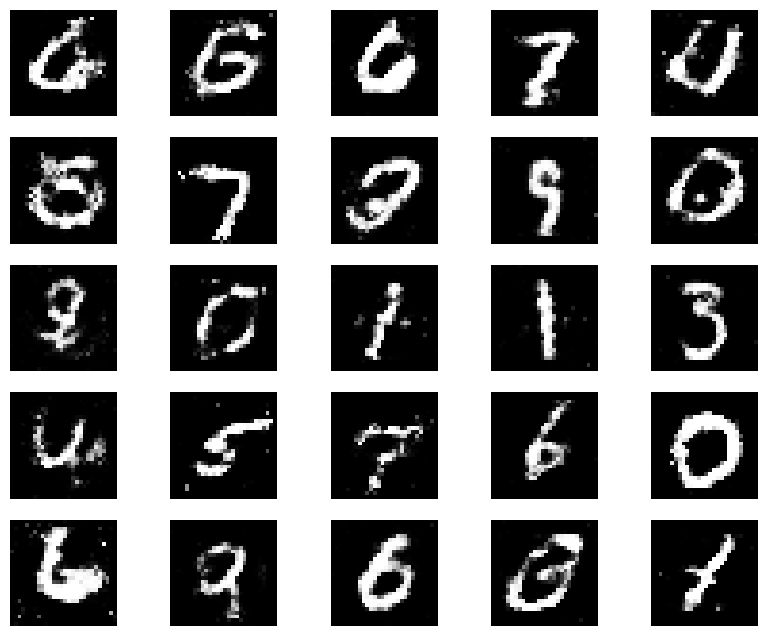

In [12]:
for epoch in range(epochs):
    # Loss for plotting
    discriminator_running_loss = 0.0
    generator_running_loss = 0.0
    # The second (y_train or '_') are the class labels which are not used
    # when training the standard GAN
    for current_step, (real_images, _) in tqdm(enumerate(train_dataloader)):
        # Place on appropriate device
        real_images = real_images.reshape(-1, flattened_image_dim).to(device)

        # Train discriminator and generator
        generator_loss = train_generator_and_get_loss(
            generator, discriminator, batch_size, latent_dim, device, gt_real, generator_optimizer)

        # Note: In production code, it is not a good idea to create functions that
        # take in many arguments. Break it down into smaller chunks
        discriminator_loss = train_discriminator_and_get_loss(
            # Networks
            generator, discriminator,
            # Real image for training discriminator
            real_images,
            # Needed to generate batch
            batch_size, latent_dim, device,
            # ground truth
            gt_real, gt_fake,
            discriminator_optimizer
        )

        # Calculate running loss
        discriminator_running_loss += discriminator_loss.item()
        generator_running_loss += generator_loss.item()

        # print stats
        if current_step % logging_interval == 0:
            # need to detach from graph before using with third-party visualization libraries
            discriminator_loss = discriminator_loss.cpu().detach().numpy()
            generator_loss = generator_loss.cpu().detach().numpy()
            print_stats(epoch, epochs, current_step, discriminator_loss, generator_loss)

    # After each epoch, visualize image
    with torch.no_grad():
        # Accumulate running loss
        generator_loss_per_epoch.append(generator_running_loss / len(train_dataloader))
        discriminator_loss_per_epoch.append(discriminator_running_loss / len(train_dataloader))

        # change to evaluation mode
        generator.eval()

        # Generate fake images to visualize
        row_count, column_count = 5, 5
        image_count = row_count * column_count
        fake_images = generate_fake_images(generator, image_count, latent_dim, device).cpu().detach()

        # Reshape from 784 to 28 x 28 since linear layers output vectors
        fake_images = fake_images.reshape(image_count, width, height)

        # Visualize generated images
        visualize_tensors(fake_images, row_count, column_count, epoch, is_jupyter = True)

        # Revert back to training mode
        generator.train()

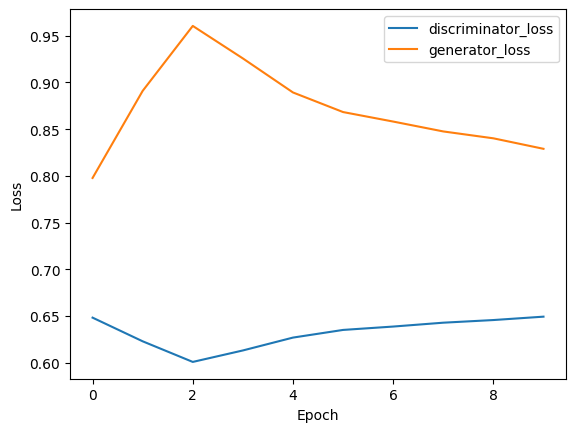

In [13]:
        
# End of training
# -------------------------------
# Lastly, visualize loss function after
visualize_loss(discriminator_loss_per_epoch, generator_loss_per_epoch, is_jupyter = True)